<h1 align="center"><font color="yellow">CNN with Tensorboard and Pytorch</font></h1>

<font color="yellow">Data Scientist.: PhD.Eddy Giusepe Chirinos Isidro</font>

In [1]:
import torch
print(torch.__version__)


2.0.1+cu117


In [2]:
%load_ext watermark 
%watermark -v -p numpy,pandas,matplotlib,torch,tensorboard


Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.13.2

numpy      : 1.24.3
pandas     : 2.0.1
matplotlib : 3.7.1
torch      : 2.0.1
tensorboard: 2.13.0



# Importando as bibliotecas e funções auxiliares

In [3]:
import torch
import torch.nn as nn
import torch.optim as opt
torch.set_printoptions(linewidth=120)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter # Nos permite Importar a classe TensorBoard


In [4]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


# Modelo CNN

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = torch.flatten(x,start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

# Importando o Dataset e criando o Loader para treinamento

In [6]:
train_set = torchvision.datasets.FashionMNIST(root="./data",
                                              train = True,
                                              download=True,
                                              transform=transforms.ToTensor()
                                             )

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=128,
                                           shuffle = True
                                          )


# Exibindo `Images` e `Graphs` com o TensorBoard:

In [ ]:
tb = SummaryWriter()

model = CNN()

images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images) # Temos 10 classes diferentes FashionMNIST

tb.add_image("Eddy: Imagens FashionMNIST", grid) # Adiciona as Imagens FashionMNIST
tb.add_graph(model, images) # Para visualizar a estrutura da nossa Rede Neural (CNN)
tb.close()


# A seguir visualizamos no TensorBoard:
%load_ext tensorboard

%tensorboard --logdir=runs



Vamos para o Browser, na seguinte URL: [http://localhost:6006/](http://localhost:6006/)

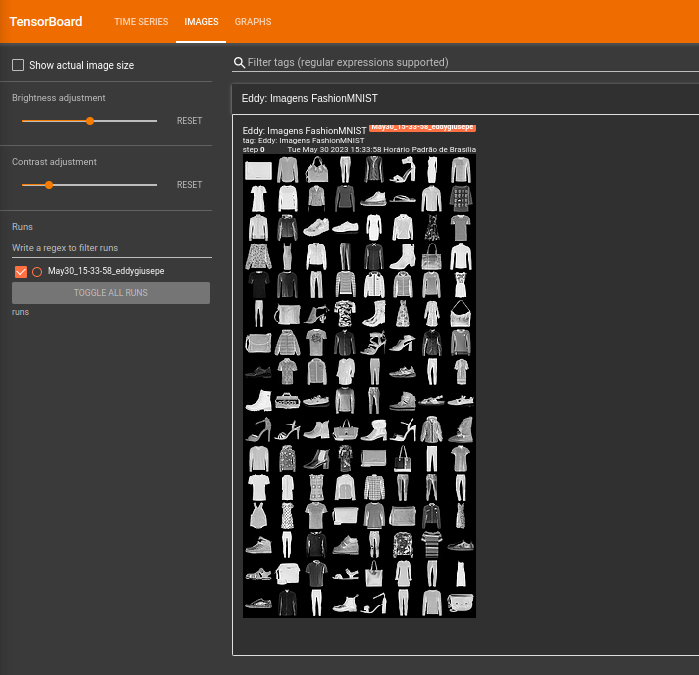

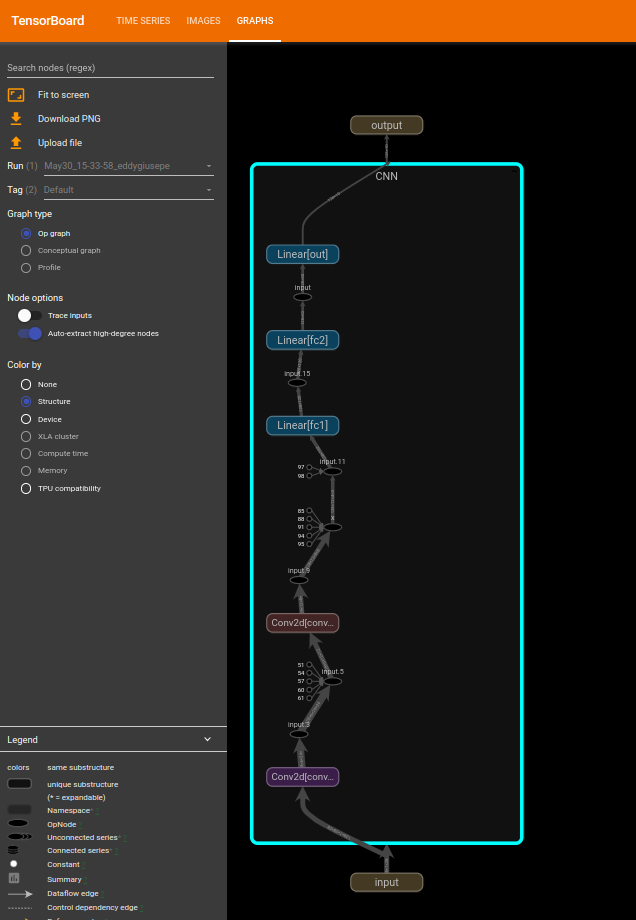

# Loop de Treinamento para visualizar a Avaliação

In [ ]:
import torch

device = ("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=128,
                                           shuffle = True
                                          )

optimizer = opt.Adam(model.parameters(), lr= 0.001)
criterion = torch.nn.CrossEntropyLoss()

tb = SummaryWriter()

for epoch in range(20):

    total_loss = 0
    total_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)

        loss = criterion(preds, labels)
        total_loss+= loss.item()
        total_correct+= get_num_correct(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tb.add_scalar("Loss", total_loss, epoch)
    tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", total_correct/ len(train_set), epoch)

    tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
    tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
    tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
    tb.add_histogram("conv2.weight", model.conv2.weight, epoch)

    print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss)

tb.close()


# A seguir visualizamos no TensorBoard:
%load_ext tensorboard

%tensorboard --logdir=runs


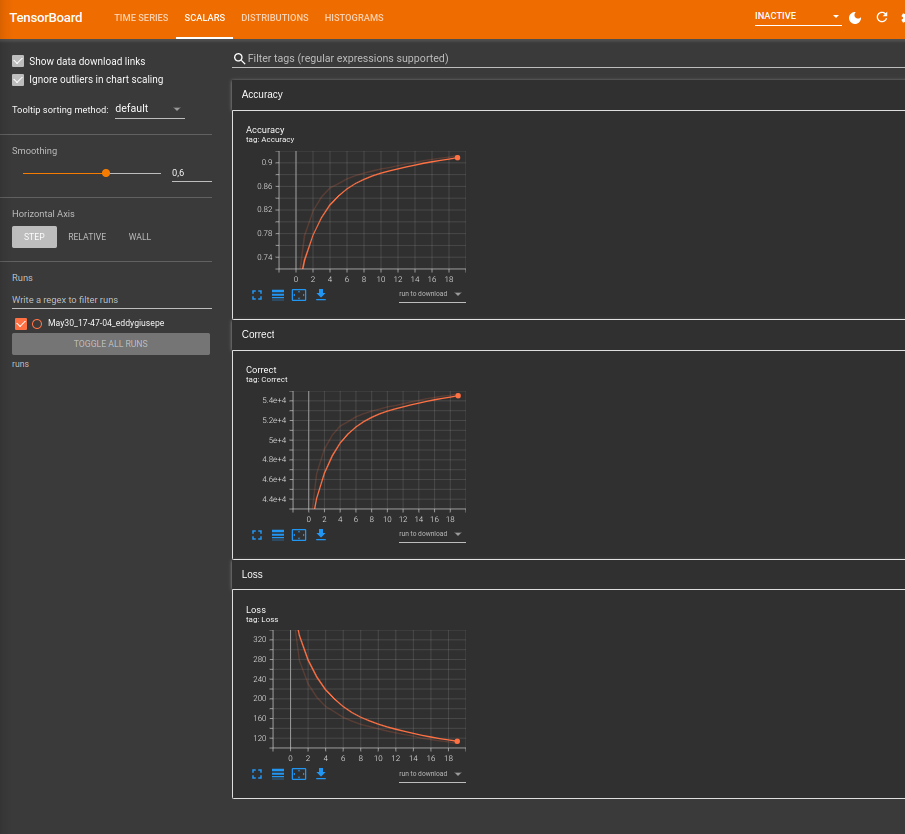

Como alternativa, também podemos usar um loop for para percorrer todos os parâmetros do modelo, incluindo as camadas `fc` e `softmax`:

In [8]:
for name, weight in model.named_parameters():
    tb.add_histogram(name,weight, epoch)
    tb.add_histogram(f'{name}.grad',weight.grad, epoch)
    

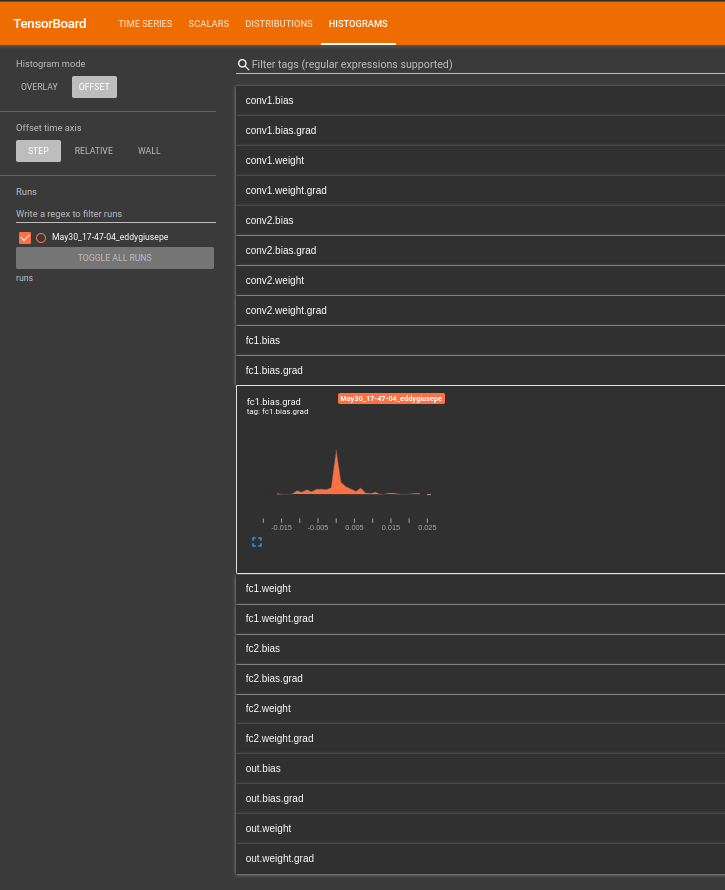

# Ajuste de hiperparâmetros

<font color="orange">Em primeiro lugar, precisamos alterar `batch_size`, `learning_rate`, `shuffle` para variáveis ​​dinâmicas. Fazemos isso criando um dicionário da seguinte forma:</font>

In [9]:
from itertools import product

parameters = dict(
    lr = [0.01, 0.001],
    batch_size = [32, 64, 128, 256],
    shuffle = [True, False]
)

param_values = [v for v in parameters.values()]
print(param_values)

for lr,batch_size, shuffle in product(*param_values):
    print(lr, batch_size, shuffle)


[[0.01, 0.001], [32, 64, 128, 256], [True, False]]
0.01 32 True
0.01 32 False
0.01 64 True
0.01 64 False
0.01 128 True
0.01 128 False
0.01 256 True
0.01 256 False
0.001 32 True
0.001 32 False
0.001 64 True
0.001 64 False
0.001 128 True
0.001 128 False
0.001 256 True
0.001 256 False


# Loop de treinamento Modificado

In [ ]:
for run_id, (lr,batch_size, shuffle) in enumerate(product(*param_values)):
    print("run id:", run_id + 1)

    model = CNN().to(device)
    
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size= batch_size, 
                                               shuffle = shuffle
                                              )
    
    optimizer = opt.Adam(model.parameters(), lr= lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    comment = f' batch_size = {batch_size} lr = {lr} shuffle = {shuffle}'
    
    tb = SummaryWriter(comment=comment)
    
    for epoch in range(5):
        total_loss = 0
        total_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)

            loss = criterion(preds, labels)
            total_loss+= loss.item()
            total_correct+= get_num_correct(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tb.add_scalar("Loss", total_loss, epoch)
        tb.add_scalar("Correct", total_correct, epoch)
        tb.add_scalar("Accuracy", total_correct/ len(train_set), epoch)

        print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
        print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss)
    print("__________________________________________________________")

    tb.add_hparams(
            {"lr": lr, "bsize": batch_size, "shuffle":shuffle},
            {
                "accuracy": total_correct/ len(train_set),
                "loss": total_loss,
            },
        )

tb.close()


# A seguir visualizamos no TensorBoard:
%load_ext tensorboard

%tensorboard --logdir=runs
